

==== DETAILED RESULTS PER METHOD ====

--- Newton ---
Iterations          : 4
Optimal Speed v*    : 41.675588 km/h
Total Fuel used     : 4.100000 L
Fuel Cost           : 418.20
Regularizer penalty : 2.210344
Total Fuel+Reg cost : 420.41

--- Steepest Descent ---
Iterations          : 6
Optimal Speed v*    : 41.675587 km/h
Total Fuel used     : 4.100000 L
Fuel Cost           : 418.20
Regularizer penalty : 2.210344
Total Fuel+Reg cost : 420.41

--- BFGS ---
Iterations          : 6
Optimal Speed v*    : 41.675588 km/h
Total Fuel used     : 4.100000 L
Fuel Cost           : 418.20
Regularizer penalty : 2.210344
Total Fuel+Reg cost : 420.41

--- Trust Region ---
Iterations          : 4
Optimal Speed v*    : 41.675588 km/h
Total Fuel used     : 4.100000 L
Fuel Cost           : 418.20
Regularizer penalty : 2.210344
Total Fuel+Reg cost : 420.41


==== COMPARISON SUMMARY ====
Method               Iter    v* (km/h)     Fuel (L)     Total Cost
----------------------------------------------------

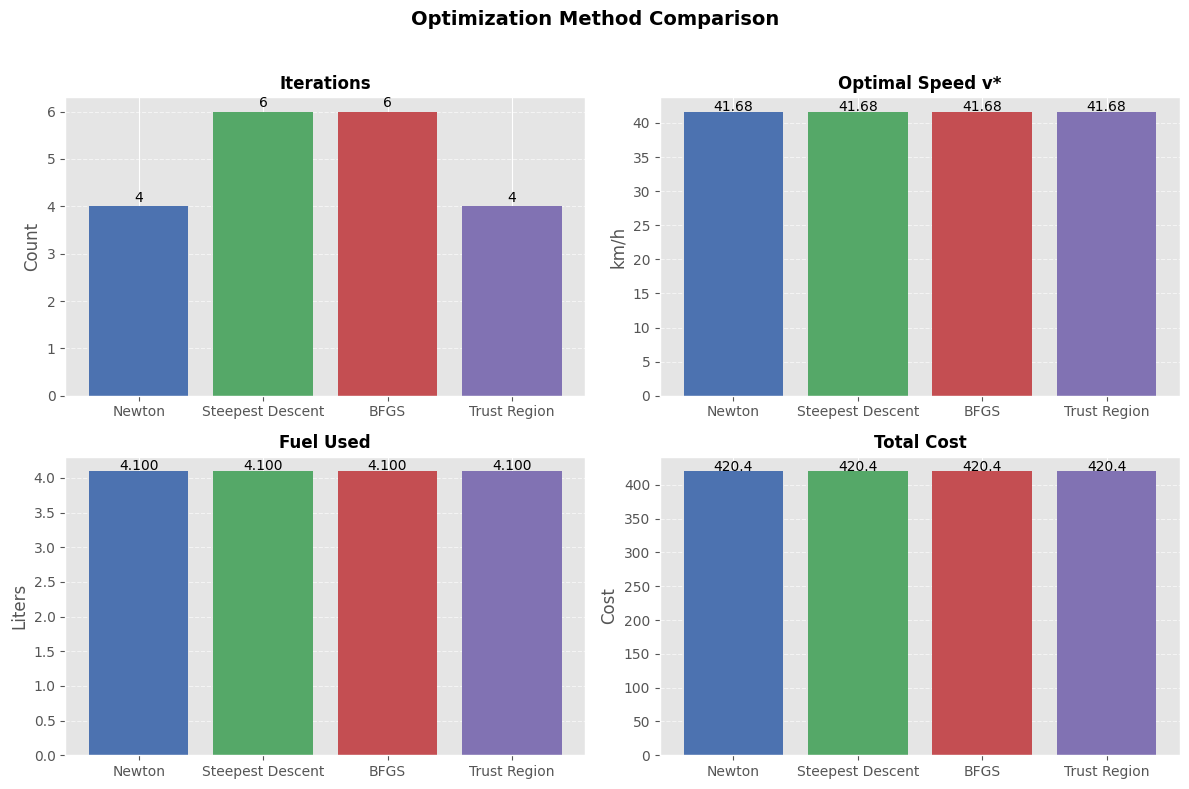

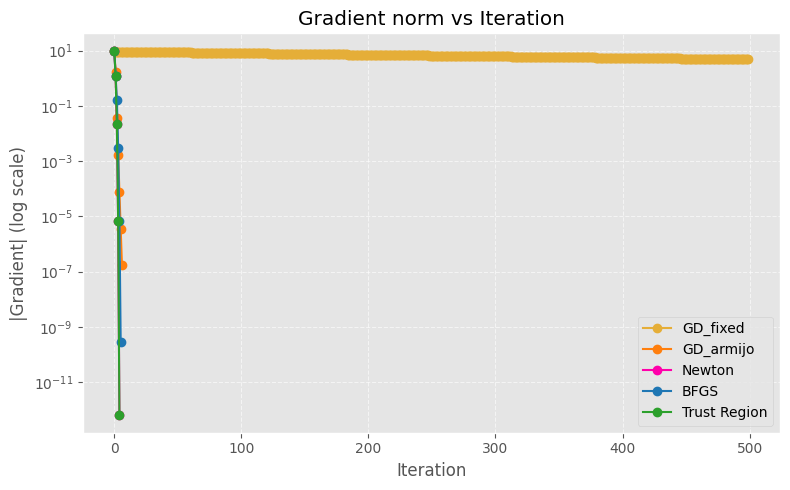

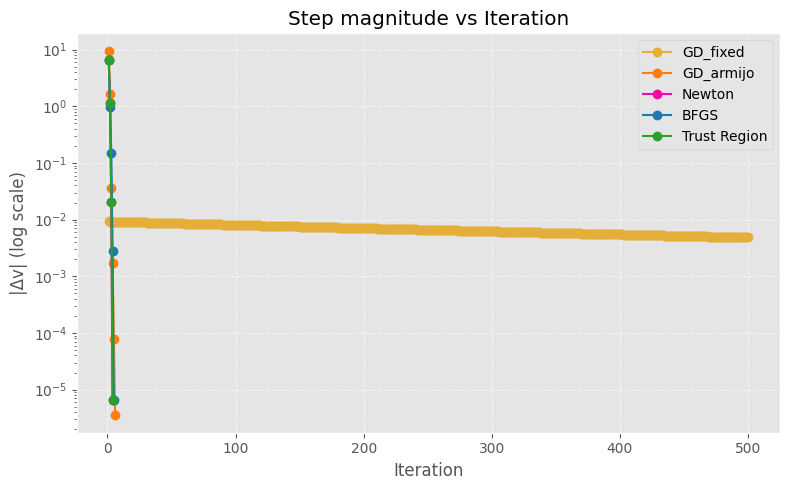

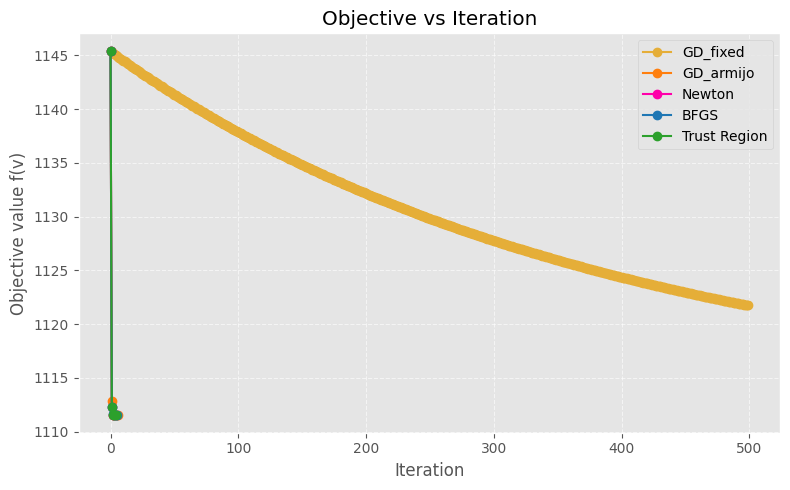

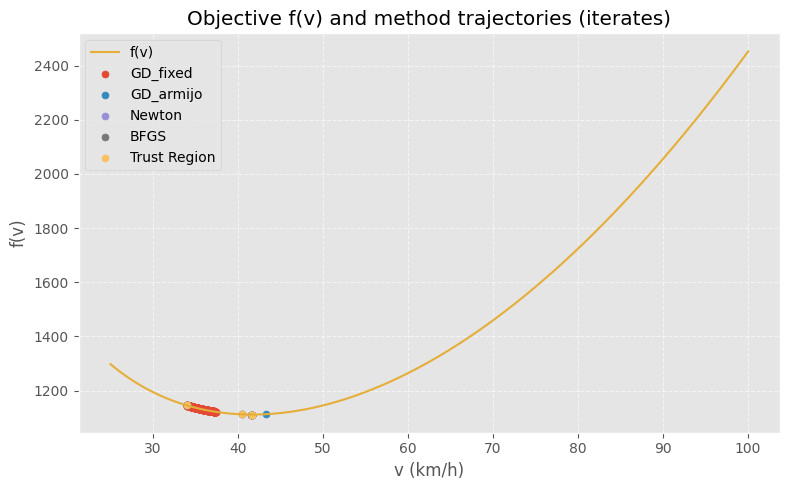

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Common Inputs
D = float(input("Distance (km): "))
tau = float(input("Traffic Index (0..1): "))   # 0 = no traffic, 1 = heavy traffic
n = int(input("Number of passengers: "))
C = float(input("Enter engine capacity (cc): ")) # Engine capacity (user input)
v_min = float(input("Enter minimum speed: "))
v_max = float(input("Enter maximum speed: "))

# -----------------------------
# Constants 
w_avg = 70.0 # avg weight (kg)
Pf = 102.0  # Fuel Price (currency per L)
Ct = 160.0  # delay constant
s = 0.05

# Preferred-speed / formula coefficients (unchanged)
c1 = 75.0
c2 = 5400.0
c3 = 4.0 / 70.0

# Small baseline fuel-speed coefficients (kept small)
ce1_base = 2e-4
ce2_base = 1e-5

# Engine-efficiency scaling for baseline coefficients
C_ref = 400.0
beta_eff = 0.20

# baseline K term
c0 = 0.005
c3_base = 0.001
c4 = 1e-5
c5 = 0.002

# Regularizer weight (same)
lambda_reg = 0.2

# Precompute scaling and baseline coefficients
B = Pf * D
eff_scale = 1.0 if C <= 0 else (C_ref / C) ** beta_eff
ce1 = ce1_base * eff_scale
ce2 = ce2_base * eff_scale
K = c0 + c3_base * tau + c4 * n * w_avg + c5 / (C if C > 0 else C_ref)


# -----------------------------
# Helper / model functions
def v_pref_formula(tau_val, C_val, n_val, w_avg_val):
    tau_clipped = np.clip(tau_val, 0.0, 1.0)
    C_safe = C_val if C_val > 0 else 1.0
    F = v_max - c1 * tau_clipped - (c2 / C_safe) - c3 * (n_val * w_avg_val)
    return float(np.clip(F, v_min, v_max))


def FC_baseline_per_km(v):
    return K + ce1 * v + ce2 * v**2


def f_base(v):
    if v <= 0:
        return float("inf")
    FC_v = FC_baseline_per_km(v)
    fuel_cost = B * FC_v
    time_cost = Ct * (D / v)
    const_delay = Ct * s * tau * D
    return fuel_cost + time_cost + const_delay


def f(v):
    vp = v_pref_formula(tau, C, n, w_avg)
    return f_base(v) + lambda_reg * (v - vp) ** 2


def fprime(v):
    base_deriv = B * (ce1 + 2.0 * ce2 * v) - Ct * D / (v**2)
    reg_deriv = 2.0 * lambda_reg * (v - v_pref_formula(tau, C, n, w_avg))
    return base_deriv + reg_deriv


def fdoubleprime(v):
    base_hess = 2.0 * B * ce2 + 2.0 * Ct * D / (v**3)
    reg_hess = 2.0 * lambda_reg
    return base_hess + reg_hess


def proj(v):
    return float(np.clip(v, v_min, v_max))


# -----------------------------
# Newton's Method
def newton_method(v0=40.0, tol=1e-6, max_iter=100, verbose=True):
    v = proj(v0)
    iterations = 0


    for k in range(1, max_iter + 1):
        g = fprime(v)
        H = fdoubleprime(v)

        if abs(g) < tol:
            iterations = k - 1
            break

        if abs(H) < 1e-14:
            iterations = k - 1
            break

        step = g / H
        v_new = proj(v - step)

        if abs(v_new - v) < tol:
            v = v_new
            iterations = k
            break

        v = v_new

    return v, iterations


# -----------------------------
# Steepest Descent (Armijo)
def steepest_descent(v0=40.0, tol=1e-6, max_iter=100, verbose=True):
    v = proj(v0)
    iterations = 0

 

    for k in range(1, max_iter + 1):
        g = fprime(v)
        if abs(g) < tol:
            iterations = k - 1
            break

        step_dir = -g
        alpha = 1.0
        f_v = f(v)

        while True:
            v_trial = proj(v + alpha * step_dir)
            if f(v_trial) <= f_v + 1e-4 * alpha * g * step_dir:
                break
            alpha *= 0.5
            if alpha < 1e-12:
                break

        v_new = v_trial

        if abs(v_new - v) < tol:
            v = v_new
            iterations = k
            break

        v = v_new

    return v, iterations


# -----------------------------
# BFGS Method (1D)
def bfgs_method(v0=40.0, tol=1e-9, max_iter=200, verbose=True):
    x = np.array([proj(v0)], dtype=float)
    g0 = float(fprime(x[0]))
    fpp0 = float(fdoubleprime(x[0]))

    inv_h0 = 1.0 / (abs(fpp0) + 1e-12)
    Hk = np.array([[inv_h0]], dtype=float)

    iter_count = 0
    alpha0 = 1.0
    c1_ls = 1e-4
    rho = 0.5
    max_line_iters = 30



    for k in range(1, max_iter + 1):
        iter_count += 1
        g = np.array([fprime(x[0])], dtype=float)
        
        if abs(g[0]) < tol:
            break

        pk = -Hk.dot(g)

        gTp = float(g.reshape(-1).dot(pk.reshape(-1)))
        if gTp >= 0:
            pk = -g
            gTp = float(g.reshape(-1).dot(pk.reshape(-1)))

        alpha = alpha0
        fx = f(x[0])
        found = False
        x_new = None

        for _ in range(max_line_iters):
            cand_unproj = x[0] + alpha * pk[0]
            cand_proj = proj(cand_unproj)
            if f(cand_proj) <= fx + c1_ls * alpha * gTp:
                x_new = np.array([cand_proj], dtype=float)
                found = True
                break
            alpha *= rho

        if not found:
            alpha = 1e-6
            cand_proj = proj(x[0] + alpha * pk[0])
            x_new = np.array([cand_proj], dtype=float)

        s = x_new - x
        g_new = np.array([fprime(x_new[0])], dtype=float)
        y = g_new - g

        sty = float(s.reshape(-1).dot(y.reshape(-1)))
        if sty > 1e-12:
            rho_b = 1.0 / sty
            I = np.eye(1)
            term1 = I - rho_b * np.outer(s, y)
            term2 = I - rho_b * np.outer(y, s)
            Hk = term1.dot(Hk).dot(term2) + rho_b * np.outer(s, s)

        x = x_new

        if np.linalg.norm(s) < tol:
            break

    return float(x[0]), iter_count


# -----------------------------
# Trust Region Method
def trust_region_optimization(v0, tol=1e-6, max_iter=100, verbose=True):
    v_k = proj(v0)
    iterations = 0

    Delta_k = 10.0
    Delta_max = 50.0
    eta = 1e-4


    for k in range(1, max_iter + 1):
        f_k = f(v_k)
        g_k = fprime(v_k)
        H_k = fdoubleprime(v_k)

        if abs(g_k) < tol:
            iterations = k - 1
            break

        if abs(H_k) < 1e-14:
            iterations = k - 1
            break

        p_star = -g_k / H_k
        p_k = np.clip(p_star, -Delta_k, Delta_k)

        v_trial = v_k + p_k
        p_actual = v_trial - v_k

        ActRed = f_k - f(v_trial)
        PredRed = -(g_k * p_actual + 0.5 * H_k * p_actual ** 2)

        if PredRed <= 0:
            rho_k = -1.0
        else:
            rho_k = ActRed / PredRed

        v_next = v_k
        Delta_next = Delta_k

        step_accepted = False

        if rho_k > eta and ActRed > 0:
            v_next = proj(v_trial)
            step_accepted = True

        if rho_k < 0.25:
            Delta_next = 0.25 * Delta_k
        elif rho_k > 0.75 and abs(p_k) == Delta_k:
            Delta_next = min(2 * Delta_k, Delta_max)

        if step_accepted and abs(v_next - v_k) < tol:
            v_k = v_next
            iterations = k
            break

        v_k = v_next
        Delta_k = Delta_next

    return v_k, iterations


# -----------------------------
# Cost computation
def compute_costs(v_opt):
    FC_base = FC_baseline_per_km(v_opt)
    baseline_fuel_used = FC_base * D

    target_total_for_D10 = 0.37 + 0.08 * tau
    target_fuel_used = target_total_for_D10 * (D / 10.0)

    delta = target_fuel_used - baseline_fuel_used

    if tau < 0.5:
        denom = (1.0 - tau) * D
        M = -delta / denom if abs(denom) > 1e-12 else 0
        FC_v = FC_base - (1.0 - tau) * M
    else:
        denom = tau * D
        N = delta / denom if abs(denom) > 1e-12 else 0
        FC_v = FC_base + tau * N

    FC_v = max(1e-12, FC_v)
    fuel_used = FC_v * D
    fuel_cost = Pf * fuel_used
    regularizer_penalty = lambda_reg * (v_opt - v_pref_formula(tau, C, n, w_avg)) ** 2
    total_cost = fuel_cost + regularizer_penalty

    return {
        "v_opt": v_opt,
        "fuel_used": fuel_used,
        "fuel_cost": fuel_cost,
        "regularizer_penalty": regularizer_penalty,
        "total_cost": total_cost,
    }


# -----------------------------
# Initial guess
v0_input = input("Initial Guess: ").strip()
if v0_input == "":
    v0 = v_pref_formula(tau, C, n, w_avg)
else:
    try:
        v0 = float(v0_input)
    except ValueError:
        v0 = v_pref_formula(tau, C, n, w_avg)
v0 = proj(v0)


# -----------------------------
# Run all methods (for final solution comparison)
results = {}
v_newton, it_newton = newton_method(v0=v0, verbose=True)
results["Newton"] = (it_newton, compute_costs(v_newton))

v_sd, it_sd = steepest_descent(v0=v0, verbose=True)
results["Steepest Descent"] = (it_sd, compute_costs(v_sd))

v_bfgs, it_bfgs = bfgs_method(v0=v0, verbose=True)
results["BFGS"] = (it_bfgs, compute_costs(v_bfgs))

v_trust, it_trust = trust_region_optimization(v0=v0, verbose=True)
results["Trust Region"] = (it_trust, compute_costs(v_trust))


# -----------------------------
# Detailed results per method
print("\n\n==== DETAILED RESULTS PER METHOD ====")
for name, (iters, metrics) in results.items():
    print(f"\n--- {name} ---")
    print(f"Iterations          : {iters}")
    print(f"Optimal Speed v*    : {metrics['v_opt']:.6f} km/h")
    print(f"Total Fuel used     : {metrics['fuel_used']:.6f} L")
    print(f"Fuel Cost           : {metrics['fuel_cost']:.2f}")
    print(f"Regularizer penalty : {metrics['regularizer_penalty']:.6f}")
    print(f"Total Fuel+Reg cost : {metrics['total_cost']:.2f}")


# -----------------------------
# Comparison summary table
print("\n\n==== COMPARISON SUMMARY ====")
print(f"{'Method':<18} {'Iter':>6} {'v* (km/h)':>12} {'Fuel (L)':>12} {'Total Cost':>14}")
print("-" * 70)
for name, (iters, metrics) in results.items():
    print(f"{name:<18} {iters:>6d} {metrics['v_opt']:>12.4f} "
          f"{metrics['fuel_used']:>12.4f} {metrics['total_cost']:>14.2f}")


# -----------------------------
# 2×2 COMPARISON BAR PLOTS
plt.style.use("ggplot")

methods = list(results.keys())
iterations = [results[m][0] for m in methods]
v_opts = [results[m][1]["v_opt"] for m in methods]
fuel_used_vals = [results[m][1]["fuel_used"] for m in methods]
total_costs = [results[m][1]["total_cost"] for m in methods]

colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Iterations
axes[0, 0].bar(methods, iterations, color=colors)
axes[0, 0].set_title("Iterations", fontsize=12, fontweight="bold")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.6)
for i, v in enumerate(iterations):
    axes[0, 0].text(i, v + 0.1, str(v), ha='center')

# Optimal Speed
axes[0, 1].bar(methods, v_opts, color=colors)
axes[0, 1].set_title("Optimal Speed v*", fontsize=12, fontweight="bold")
axes[0, 1].set_ylabel("km/h")
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.6)
for i, v in enumerate(v_opts):
    axes[0, 1].text(i, v + 0.1, f"{v:.2f}", ha='center')

# Fuel Used
axes[1, 0].bar(methods, fuel_used_vals, color=colors)
axes[1, 0].set_title("Fuel Used", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("Liters")
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.6)
for i, v in enumerate(fuel_used_vals):
    axes[1, 0].text(i, v + 0.01, f"{v:.3f}", ha='center')

# Total Cost
axes[1, 1].bar(methods, total_costs, color=colors)
axes[1, 1].set_title("Total Cost", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Cost")
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.6)
for i, v in enumerate(total_costs):
    axes[1, 1].text(i, v + 0.5, f"{v:.1f}", ha='center')

plt.suptitle("Optimization Method Comparison", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# ======================================================
# EXTRA: ITERATION-LEVEL HISTORIES FOR DIAGNOSTIC PLOTS
# (GD_fixed, GD_armijo, Newton, BFGS, Trust Region)
# ======================================================

def gd_fixed_with_history(v0, alpha=1e-3, tol=1e-6, max_iter=500):
    v = proj(v0)
    history = {"v": [], "g": [], "f": [], "step": []}
    for k in range(max_iter):
        f_v = f(v)
        g_v = fprime(v)
        history["v"].append(v)
        history["f"].append(f_v)
        history["g"].append(g_v)

        if abs(g_v) < tol:
            break

        v_new = proj(v - alpha * g_v)
        history["step"].append(abs(v_new - v))
        v = v_new
    return history


def gd_armijo_with_history(v0, tol=1e-6, max_iter=200):
    v = proj(v0)
    history = {"v": [], "g": [], "f": [], "step": []}
    for k in range(max_iter):
        g_v = fprime(v)
        f_v = f(v)
        history["v"].append(v)
        history["f"].append(f_v)
        history["g"].append(g_v)

        if abs(g_v) < tol:
            break

        step_dir = -g_v
        alpha = 1.0
        while True:
            v_trial = proj(v + alpha * step_dir)
            if f(v_trial) <= f_v + 1e-4 * alpha * g_v * step_dir:
                break
            alpha *= 0.5
            if alpha < 1e-12:
                break

        v_new = v_trial
        history["step"].append(abs(v_new - v))

        if abs(v_new - v) < tol:
            v = v_new
            break

        v = v_new
    return history


def newton_with_history(v0, tol=1e-9, max_iter=50):
    v = proj(v0)
    history = {"v": [], "g": [], "f": [], "step": []}
    for k in range(max_iter):
        f_v = f(v)
        g_v = fprime(v)
        H_v = fdoubleprime(v)
        history["v"].append(v)
        history["f"].append(f_v)
        history["g"].append(g_v)

        if abs(g_v) < tol or abs(H_v) < 1e-14:
            break

        step = g_v / H_v
        v_new = proj(v - step)
        history["step"].append(abs(v_new - v))

        if abs(v_new - v) < tol:
            v = v_new
            break

        v = v_new
    return history


def bfgs_with_history(v0, tol=1e-9, max_iter=50):
    x = np.array([proj(v0)], dtype=float)
    fpp0 = float(fdoubleprime(x[0]))
    Hk = np.array([[1.0 / (abs(fpp0) + 1e-12)]], dtype=float)

    history = {"v": [], "g": [], "f": [], "step": []}
    alpha0 = 1.0
    c1_ls = 1e-4
    rho = 0.5
    max_line_iters = 30

    for k in range(1, max_iter + 1):
        v = float(x[0])
        f_v = f(v)
        g = np.array([fprime(v)], dtype=float)

        history["v"].append(v)
        history["f"].append(f_v)
        history["g"].append(g[0])

        if abs(g[0]) < tol:
            break

        pk = -Hk.dot(g)
        gTp = float(g.reshape(-1).dot(pk.reshape(-1)))
        if gTp >= 0:
            pk = -g
            gTp = float(g.reshape(-1).dot(pk.reshape(-1)))

        alpha = alpha0
        fx = f(v)
        found = False

        for _ in range(max_line_iters):
            cand_unproj = v + alpha * pk[0]
            cand_proj = proj(cand_unproj)
            f_cand = f(cand_proj)
            if f_cand <= fx + c1_ls * alpha * gTp:
                x_new = np.array([cand_proj], dtype=float)
                found = True
                break
            alpha *= rho

        if not found:
            alpha = 1e-6
            cand_proj = proj(v + alpha * pk[0])
            x_new = np.array([cand_proj], dtype=float)

        s = x_new - x
        g_new = np.array([fprime(x_new[0])], dtype=float)
        y = g_new - g

        history["step"].append(abs(x_new[0] - x[0]))

        sty = float(s.reshape(-1).dot(y.reshape(-1)))
        if sty > 1e-12:
            rho_b = 1.0 / sty
            I = np.eye(1)
            term1 = I - rho_b * np.outer(s, y)
            term2 = I - rho_b * np.outer(y, s)
            Hk = term1.dot(Hk).dot(term2) + rho_b * np.outer(s, s)

        x = x_new

        if np.linalg.norm(s) < tol:
            break

    return history


def trust_region_with_history(v0, tol=1e-6, max_iter=100):
    v_k = proj(v0)
    history = {"v": [], "g": [], "f": [], "step": []}

    Delta_k = 10.0
    Delta_max = 50.0
    eta = 1e-4

    for k in range(1, max_iter + 1):
        f_k = f(v_k)
        g_k = fprime(v_k)
        H_k = fdoubleprime(v_k)

        history["v"].append(v_k)
        history["f"].append(f_k)
        history["g"].append(g_k)

        if abs(g_k) < tol or abs(H_k) < 1e-14:
            break

        p_star = -g_k / H_k
        p_k = np.clip(p_star, -Delta_k, Delta_k)

        v_trial = v_k + p_k
        p_actual = v_trial - v_k

        ActRed = f_k - f(v_trial)
        PredRed = -(g_k * p_actual + 0.5 * H_k * p_actual**2)

        if PredRed <= 0:
            rho_k = -1.0
        else:
            rho_k = ActRed / PredRed

        v_next = v_k
        Delta_next = Delta_k
        step_accepted = False

        if rho_k > eta and ActRed > 0:
            v_next = proj(v_trial)
            step_accepted = True

        if rho_k < 0.25:
            Delta_next = 0.25 * Delta_k
        elif rho_k > 0.75 and abs(p_k) == Delta_k:
            Delta_next = min(2 * Delta_k, Delta_max)

        if step_accepted:
            history["step"].append(abs(v_next - v_k))
        else:
            history["step"].append(0.0)

        if step_accepted and abs(v_next - v_k) < tol:
            v_k = v_next
            break

        v_k = v_next
        Delta_k = Delta_next

    return history


# Run histories starting from SAME initial guess v0
hist_gd_fixed   = gd_fixed_with_history(v0)
hist_gd_armijo  = gd_armijo_with_history(v0)
hist_newton     = newton_with_history(v0)
hist_bfgs       = bfgs_with_history(v0)
hist_trust      = trust_region_with_history(v0)

# For plotting
methods_hist = ["GD_fixed", "GD_armijo", "Newton", "BFGS", "Trust Region"]
histories = {
    "GD_fixed": hist_gd_fixed,
    "GD_armijo": hist_gd_armijo,
    "Newton": hist_newton,
    "BFGS": hist_bfgs,
    "Trust Region": hist_trust,
}
line_colors = {
    "GD_fixed": "#E5AE38",
    "GD_armijo": "#FF7F0E",
    "Newton": "#FF00AA",
    "BFGS": "#1F77B4",
    "Trust Region": "#2CA02C",
}

# 1) Gradient norm vs iteration (log scale)
plt.figure(figsize=(8, 5))
for m in methods_hist:
    g_vals = np.abs(np.array(histories[m]["g"]))
    its = np.arange(len(g_vals))
    plt.semilogy(its, g_vals, marker="o", label=m, color=line_colors[m])
plt.title("Gradient norm vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("|Gradient| (log scale)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# 2) Step magnitude vs iteration (log scale)
plt.figure(figsize=(8, 5))
for m in methods_hist:
    steps = np.array(histories[m]["step"])
    if len(steps) == 0:
        continue
    its = np.arange(1, len(steps) + 1)
    plt.semilogy(its, steps, marker="o", label=m, color=line_colors[m])
plt.title("Step magnitude vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("|Δv| (log scale)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# 3) Objective vs iteration
plt.figure(figsize=(8, 5))
for m in methods_hist:
    f_vals = np.array(histories[m]["f"])
    its = np.arange(len(f_vals))
    plt.plot(its, f_vals, marker="o", label=m, color=line_colors[m])
plt.title("Objective vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective value f(v)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# 4) Objective f(v) and method trajectories in v–space
v_grid = np.linspace(v_min, v_max, 400)
f_grid = np.array([f(vv) for vv in v_grid])

plt.figure(figsize=(8, 5))
plt.plot(v_grid, f_grid, color="#E5AE38", label="f(v)")
for m in methods_hist:
    v_vals = np.array(histories[m]["v"])
    f_vals = np.array(histories[m]["f"])
    plt.scatter(v_vals, f_vals, label=m, s=25)
plt.title("Objective f(v) and method trajectories (iterates)")
plt.xlabel("v (km/h)")
plt.ylabel("f(v)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()
